<div class="alert alert-info"> 
<h3>TASK</h3>
<br>
With log data of user visits, customer orders and monthly marketing expenses, <b>I was assigned to calculate several business metrics to help optimize the marketing expenses.</b>
<br>
<br> Marketing expenses were different for each ad source where users visits came from.
</div>

<div class="alert alert-warning"> 
<h3>APPROACH</h3>
<br>
Some metrics chosen for calculation were:
<br>+ <a href="#part_2a">DAU, WAU, MAU and sticky factors</a>
<br>+ <a href="#part_2c">Users retention and churn rate</a>
<br>+ <a href="#part_3b">Customer 1-day/week/month conversion rate</a>
<br>+ <a href="#part_3c">Customer lifetime value (LTV)</a>
<br>+ <a href="#part_4b">Customer acquisition cost (CAC)</a>
<br>+ <a href="#part_4c">Return on marketing investment (ROMI)</a>
<br>
<br> The analysis were performed for different user cohorts and marketing sources.
</div>

<div class="alert alert-success"> 
<h3>RESULT</h3>
<br>
<a href="#part_5">The result</a> provided a general views of current marketing investments worthiness and gave ground for expenses proportion adjustment.
</div>

# PROJECT: Optimize marketing expenses for Yandex.Afisha
### TABLE OF CONTENT:

* [PART_1> Data Preparation](#part_1)
    + [Data Overview & Preprocessing](#part_1a)
    + [Data Calculation](#part_1b)

* [PART_2> Product](#part_2)
    + [Visits traffic](#part_2a)
    + [Where did users come frome?](#part_2b)
    + [Did users come back?](#part_2c)

* [PART_3> Sales](#part_3)
    + [Orders traffic](#part_3a)
    + [When did users start buying?](#part_3b)
    + [How much money did customers bring?](#part_3c)

* [PART_4> Marketing](#part_4)
    + [Marketing cost](#part_4a)
    + [How much did customer acquisition cost?](#part_4b)
    + [How worthwhile were the investments?](#part_4c)
  
* [PART_5> Final Conclusion](#part_4) 

---

In [1]:
# IMPORT PACKAGES USED FOR PROJECT-------------------------------------------------#

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

path = '/datasets/'
os.chdir(path)
#-
time = {'day' : 'datetime64[D]',
        'week' : 'datetime64[W]', # week count from Thursday because 1/1/1970 was Thursday
        'month': 'datetime64[M]'}

# LIST OF FUNCTIONS USED FOR PROJECT-----------------------------------------------#

def Overview_DataFrame_Dictionary(dfs_dict, keys = None):
    """
    This functions OVERVIEW EACH DATAFRAME (keys) that present in DATAFRAME DICTIONARY (dfs_dict)
    + df.info(), df.head(), df.describe(). df.hist()
    + Notice lists of dataframe with missing data or duplicated rows
    """
    if keys is None:
        keys = list(dfs_dict.keys())
    else:
        keys = [key for key in keys if key in dfs_dict.keys()]

    print('List of dataframe:', keys)
    print()

    dfs_missing_data = []
    dfs_duplicates = []

    for df in keys:
        if dfs_dict[df].isnull().values.any():
            dfs_missing_data.append(df)
        if dfs_dict[df].duplicated().values.any():
            dfs_duplicates.append(df)

        print('OVERVIEW', df.upper(), '-'*50)
        print()

        print(dfs_dict[df].info())
        display(dfs_dict[df].drop(dfs_dict[df].index[5:-5]))
        print()
        display(dfs_dict[df].describe())
        print()

        dfs_dict[df].hist(bins = 50)
        plt.show()

    print('*NOTICE*')
    print('Dataframes with missing values:', dfs_missing_data)
    print('Dataframes with duplicated rows:', dfs_duplicates)
        
    print('-'*50)
    print()



def Pivot_Columns_Percentage (df, index, column, value, aggfunc):

    table = df.pivot_table(index=index, columns= column, values=value, aggfunc=aggfunc)

    total = table.sum(axis=1)
    for col in table.columns:
        table[col] = table[col]/total*100

    return table


def Cohort_Retention (df, user='uid', firstdate='first_visit', lifetime='lifetime_visit', timeunit='M', heatmap=True, figsize=(10,8)):
    t = 'datetime64[{}]'.format(timeunit)
    cohorts = df.groupby(
        [df[firstdate].astype(t).dt.strftime('%Y-%m-%d'), (df[lifetime]/np.timedelta64(1, timeunit)).round().astype('int')] # cohorts groupby firstdate and lifetime
        )[user].nunique().reset_index() # count number of users at different lifetime

    initial_users_count = cohorts[cohorts[lifetime] == 0][[firstdate, user]].rename(columns={user:'cohort_users'}) # determine cohort_users as number of users at 0 lifetime
    cohorts = cohorts.merge(initial_users_count,on=firstdate) 

    cohorts['retention'] = cohorts[user]/cohorts['cohort_users'] # calculate retention
    

    if heatmap: # seaborn heatmap (optional)
        pivot = cohorts.pivot_table(index=firstdate,columns=lifetime,values='retention',aggfunc='sum')
        pivot.loc['average'] = pivot.mean()
        plt.figure(figsize=figsize)
        plt.title('Cohort Retention Rate Heatmap')
        sns.heatmap(pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray')
    return cohorts   



def Cohort_Churn (df, user='uid', firstdate='first_visit', lifetime='lifetime_visit', timeunit='M', heatmap=True, figsize=(10,8)):
    t = 'datetime64[{}]'.format(timeunit)
    cohorts = df.groupby(
        [df[firstdate].astype(t).dt.strftime('%Y-%m-%d'),(df[lifetime]/np.timedelta64(1, timeunit)).round().astype('int')] # cohorts groupby firstdate and lifetime
        )[user].nunique().reset_index() # count number of users at different lifetime
    
    cohorts['churn'] = cohorts.groupby(firstdate)[user].pct_change() # calculate % churn rate
    
    if heatmap: # seaborn heatmap (optional)
        pivot = cohorts.pivot_table(index=firstdate,columns=lifetime,values='churn',aggfunc='sum')
        pivot.loc['average'] = pivot.mean()
        plt.figure(figsize=figsize)
        plt.title('Cohort Churn Rate Heatmap')
        sns.heatmap(pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray')
    return cohorts


def CVR_Time (stage1, stage2, time1 = 'start_ts', time2 = 'buy_ts', user = 'uid', timelevels =['D', 'W', 'M'], total=True):

    first1 = stage1.groupby(user)[time1].min().reset_index()
    first2 = stage2.groupby(user)[time2].min().reset_index()
    df = first1.merge(first2, on=user, how='left')

    df['conversion_time'] = df[time2] - df[time1]
    df['conversion_time'].where(df['conversion_time']>=pd.Timedelta(0), other=float('nan'), inplace=True)

    CVR = []
    for level in timelevels: # level to round up conversion_time
        CVR.append(df[round(df['conversion_time']/np.timedelta64(1,level)) == 0][user].nunique()/df[user].nunique()*100)

    if total:
        CVR.append(df[~df['conversion_time'].isna()][user].nunique()/df[user].nunique()*100)

    return CVR


def Cohort_LTV(df, firstdate='first_order', date='buy_ts', user='uid', revenue='revenue', margin=1, timeunit='M', heatmap=True, figsize=(10,8)):
    t = 'datetime64[{}]'.format(timeunit)
    cohorts = df.groupby([df[firstdate].astype(t),df[date].astype(t)]).agg({revenue: 'sum'}).reset_index() # cohorts groupby firstdate and date, calculate revenue sum

    cohort_sizes = df.groupby(df[firstdate].astype(t))[user].nunique().reset_index()
    cohort_sizes.columns = [firstdate, 'n_buyers'] # determine cohorts size

    report = cohorts.merge(cohort_sizes, on=firstdate)

    report['lifetime'] = ((report[date] - report[firstdate]) / np.timedelta64(1, timeunit)).round().astype('int64')

    if margin != 1:
        report['gp'] = report[revenue]*margin

    report['ltv'] = report[revenue]*margin / report['n_buyers']

    if heatmap:
        report[firstdate] = report[firstdate].dt.strftime('%Y-%m-%d')
        pivot = report.pivot_table(index=firstdate, columns='lifetime', values='ltv', aggfunc='sum').cumsum(axis=1)
        pivot.loc['average'] = pivot.mean()
        plt.figure(figsize=figsize)
        plt.title('CUSTOMER LTV BY COHORTS')
        sns.heatmap(pivot, annot=True, linewidths=1, linecolor='gray')
        plt.show()
    
    return report


# DATA PREPARATION <a id="part_1"></a>

---

# Data Overview & Preprocessing <a id="part_1a"></a>
There are 3 datasets:
+ "visits" : server logs with data on Yandex.Afisha visits from June 2017 through May 2018
+ "orders" : dump file with all orders for the period
+ "expenses": marketing expenses statistics

__________ OPEN LIST OF DATA AND OVERVIEW __________

List of dataframe: ['visits', 'orders', 'expenses']

OVERVIEW VISITS --------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB
None


,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485
359399,touch,2017-09-10 13:13:19,2,2017-09-10 13:13:00,18396128934054549559


,source_id,uid
count,359400.000000,3.594000e+05
mean,3.750515,9.202557e+18
std,1.917116,5.298433e+18
min,1.000000,1.186350e+13
25%,3.000000,4.613407e+18
50%,4.000000,9.227413e+18
75%,5.000000,1.372824e+19
max,10.000000,1.844668e+19


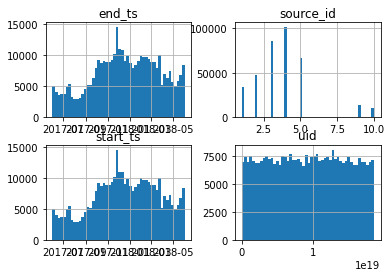

OVERVIEW ORDERS --------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB
None


,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
50410,2018-05-31 23:50:00,4.64,12296626599487328624
50411,2018-05-31 23:50:00,5.80,11369640365507475976
50412,2018-05-31 23:54:00,0.30,1786462140797698849
50413,2018-05-31 23:56:00,3.67,3993697860786194247
50414,2018-06-01 00:02:00,3.42,83872787173869366


,revenue,uid
count,50415.000000,5.041500e+04
mean,4.999647,9.098161e+18
std,21.818359,5.285742e+18
min,0.000000,3.135781e+14
25%,1.220000,4.533567e+18
50%,2.500000,9.102274e+18
75%,4.890000,1.368290e+19
max,2633.280000,1.844617e+19


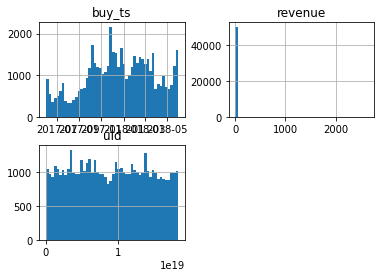

OVERVIEW EXPENSES --------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB
None


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15
2541,10,2018-05-31,17.60


,source_id,costs
count,2542.000000,2542.000000
mean,4.857199,129.477427
std,3.181581,156.296628
min,1.000000,0.540000
25%,2.000000,21.945000
50%,4.000000,77.295000
75%,9.000000,170.065000
max,10.000000,1788.280000


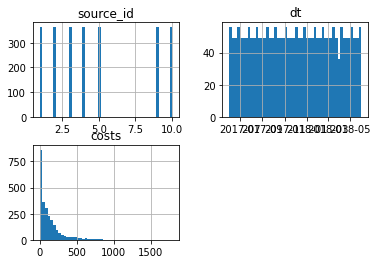

*NOTICE*
Dataframes with missing values: []
Dataframes with duplicated rows: []
--------------------------------------------------



In [2]:
print('_'*10, 'OPEN LIST OF DATA AND OVERVIEW', '_'*10)
print()

# define list of csv files and path
files = {'visits': 'visits_log_us.csv',
        'orders': 'orders_log_us.csv',
        'expenses': 'costs_us.csv'}

# read csv files and overview
dfs = {key: pd.read_csv(files[key]) for key in files}

for key in dfs:
    dfs[key].columns = dfs[key].columns.str.lower().str.replace(' ','_') #fix column name

    datecolumns = [col for col in dfs[key].columns if ('_ts' in col) | ('dt' in col)]
    dfs[key][datecolumns] = dfs[key][datecolumns].apply(pd.to_datetime) # datetime data type

Overview_DataFrame_Dictionary(dfs)

In [3]:
print('_'*10, 'CHECK FOR DUPLICATED TIME', '_'*10)
print('+ Percentage of duplicated visit start_ts:', len(dfs['visits'][dfs['visits'][['uid','start_ts']].duplicated()])/len(dfs['visits'])*100,'%')
display(dfs['visits'][dfs['visits'][['uid','start_ts']].duplicated(keep=False)])
dfs['visits'].drop_duplicates(subset=['uid','start_ts'], inplace=True) # drop
print()

print('+ Percentage of duplicated order buy_ts:', len(dfs['orders'][dfs['orders'][['uid','buy_ts']].duplicated()])/len(dfs['orders'])*100,'%')
print()

print('+ Percentage of duplicated expense dt:', len(dfs['expenses'][dfs['expenses'][['source_id','dt']].duplicated()])/len(dfs['expenses'])*100,'%')

__________ CHECK FOR DUPLICATED TIME __________
+ Percentage of duplicated visit start_ts: 0.0002782415136338341 %


,device,end_ts,source_id,start_ts,uid
44993,touch,2018-03-16 08:57:00,1,2018-03-16 08:55:00,1981020429381477763
47067,touch,2018-03-16 08:55:00,1,2018-03-16 08:55:00,1981020429381477763



+ Percentage of duplicated order buy_ts: 0.0 %

+ Percentage of duplicated expense dt: 0.0 %


# Data Calculation <a id="part_1b"></a>

__________ VISITS DATASET CALCULATION __________

+ Calculation duration of visit session in minutes
count    359399.000000
mean         10.716360
std          16.619295
min         -46.000000
25%           2.000000
50%           5.000000
75%          14.000000
max         711.000000
Name: duration_min, dtype: float64
Percentage of negative duration_min visit session: 0.0005564845756387747 %


,device,end_ts,source_id,start_ts,uid,duration_min
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986,-32
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453,-46


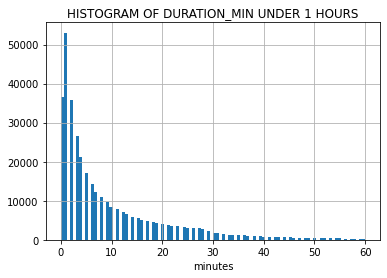

+ Calculate uid_visits as number of visits for each user
count    228169.000000
mean          1.575135
std           4.646787
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         893.000000
Name: uid_visits, dtype: float64

+ Calculate lifetime_visit as time gap between current visit and first_visit
count                        359397
mean     30 days 02:53:55.156386948
std      66 days 07:06:58.084454854
min                 0 days 00:00:00
25%                 0 days 00:00:00
50%                 0 days 00:00:00
75%                15 days 02:34:00
max               364 days 08:54:00
Name: lifetime_visit, dtype: object

+ Calculate visit_gap as time gap between current visit and previous_visit
count                        131228
mean     28 days 02:39:36.263449873
std      49 days 17:29:57.122994061
min                 0 days 00:01:00
25%                 0 days 16:17:00
50%                 4 days 21:44:00
75%                31 days 23:09

In [4]:
print('_'*10, 'VISITS DATASET CALCULATION', '_'*10)
print()

print('+ Calculation duration of visit session in minutes')
dfs['visits']['duration_min'] = ((dfs['visits']['end_ts'] - dfs['visits']['start_ts'])/np.timedelta64(1, 'm')).astype('int64')
print(dfs['visits']['duration_min'].describe())

print('Percentage of negative duration_min visit session:', len(dfs['visits'][dfs['visits']['duration_min'] < 0])/len(dfs['visits'])*100, '%')
display(dfs['visits'][dfs['visits']['duration_min'] < 0])
dfs['visits'] = dfs['visits'][dfs['visits']['duration_min']>=0] # drop negative visit duration

ax = dfs['visits']['duration_min'].hist(bins=100, range=(0,60))
ax.set_title('HISTOGRAM OF DURATION_MIN UNDER 1 HOURS')
ax.set_xlabel('minutes')
plt.show()

print('+ Calculate uid_visits as number of visits for each user')
dfs['visits']['uid_visits'] = dfs['visits'].groupby('uid')['start_ts'].transform('count')
print(dfs['visits'][['uid', 'uid_visits']].drop_duplicates()['uid_visits'].describe())
print()

print('+ Calculate lifetime_visit as time gap between current visit and first_visit')
dfs['visits']['first_visit'] = dfs['visits'].groupby('uid')['start_ts'].transform('min')
dfs['visits']['lifetime_visit'] = dfs['visits']['start_ts'] - dfs['visits']['first_visit']
print(dfs['visits']['lifetime_visit'].describe())
print()

print('+ Calculate visit_gap as time gap between current visit and previous_visit')
dfs['visits']['previous_visit'] =  dfs['visits'].sort_values(['uid', 'start_ts']).groupby('uid')['start_ts'].shift()
dfs['visits']['visit_gap'] = dfs['visits']['start_ts'] - dfs['visits']['previous_visit']
print(dfs['visits']['visit_gap'].describe())

### COMMENT:
+ Majority of visit sessions have duration about 2-14 min. Duration average is around 10 min, median at 5 min.  
*Detect and drop 2 cases of negative duration visit session*

+ At least 75% of users just have 1 visit records through the year. Therefore, majority of recorded visits have 0 lifetime.

+ For users that come back, repeat visits mostly happen within 1 month. 

In [5]:
print('_'*10, 'ORDERS DATASET CALCULATION', '_'*10)
print()

print('+ Calculate uid_orders as number of orders and uid_revenue as total revenue for each customer')
dfs['orders']['uid_orders'] = dfs['orders'].groupby('uid')['buy_ts'].transform('count')
dfs['orders']['uid_revenue'] = dfs['orders'].groupby('uid')['revenue'].transform('sum')
print(dfs['orders'][['uid', 'uid_orders', 'uid_revenue']].drop_duplicates()[['uid_orders', 'uid_revenue']].describe())
# drop_duplicates() for correct distribution
print()

print('+ Calculate lifetime_order as time gap between current order and first_order')
dfs['orders']['first_order'] = dfs['orders'].groupby('uid')['buy_ts'].transform('min')
dfs['orders']['lifetime_order'] = dfs['orders']['buy_ts'] - dfs['orders']['first_order']
print(dfs['orders']['lifetime_order'].describe())
print()

print('+ Calculate order_gap as time gap between current order and previous_order')
dfs['orders']['previous_order'] =  dfs['orders'].sort_values(['uid', 'buy_ts']).groupby('uid')['buy_ts'].shift()
dfs['orders']['order_gap'] = dfs['orders']['buy_ts'] - dfs['orders']['previous_order']
print(dfs['orders']['order_gap'].describe())

__________ ORDERS DATASET CALCULATION __________

+ Calculate uid_orders as number of orders and uid_revenue as total revenue for each customer
         uid_orders   uid_revenue
count  36523.000000  36523.000000
mean       1.380363      6.901328
std        3.454461     88.128535
min        1.000000      0.000000
25%        1.000000      1.470000
50%        1.000000      3.050000
75%        1.000000      5.800000
max      239.000000  11810.180000

+ Calculate lifetime_order as time gap between current order and first_order
count                         50415
mean     19 days 10:04:06.850342160
std      53 days 07:06:48.525061386
min                 0 days 00:00:00
25%                 0 days 00:00:00
50%                 0 days 00:00:00
75%                 0 days 02:41:00
max               363 days 19:59:00
Name: lifetime_order, dtype: object

+ Calculate order_gap as time gap between current order and previous_order
count                         13892
mean     25 days 12:38:24.380938670


### COMMENT:
+ Similar to visit activity, majority of customers have only 1 recorded order and bringing on average around 7$ revenue.

+ For customer that come back, repeat orders mostly happen in less than 1 month.

# PRODUCT  <a id="part_2"></a>
---
### SUMMARY:
+ Daily: 1000 visits - 900 visitors.  DAU/WAU ~16% and DAU/MAU ~4%.  

+ Visit flow is high from October to March. Most visit is around 2-14 min (5 min in median).

+ 1-months retention rate around 7%. Most repeat visits have time gap within 1 month.

+ Dominant visit sources are source 3,4 and 5 followed by source 1 and 2. Visits from source 1, 2 have higher average duration (~15-20 min) than other sources.

+ Ratio between desktop and touch visits around 3:1. Desktop visits tends to be a little longer (~12min).




# Visit traffic <a id="part_2a"></a>

__________ ASSESSING VISITS BY DATE __________



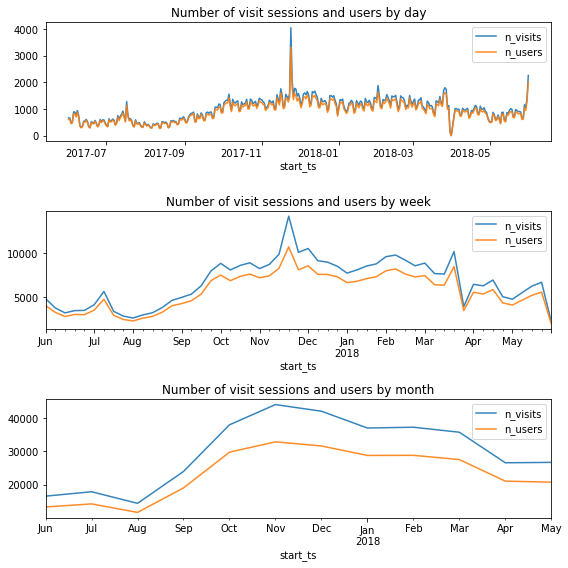


Sticky factor DAU/WAU: 15.861738592989047 %
Sticky factor DAU/MAU: 3.908969652437603 %
NOTE: DAU, WAU and MAU are average number of users by day, week and month.


,day_average,week_average,month_average,total
n_visits,987.354396,6781.075472,29949.750000,359397.000000
n_users,907.991758,5724.415094,23228.416667,228169.000000
n_visits/user,1.087405,1.184588,1.289358,1.575135


In [6]:
print('_'*10, 'ASSESSING VISITS BY DATE', '_'*10)
print()

visits_date_ave = pd.DataFrame([])             # report of average n_visits/n_users
fig, axes = plt.subplots(3, figsize=(8, 8))    # plot of n_visits/n_users through time

a=0
for level in time:    # to round up 'start_ts' to date/week/month level
    
    # groupby round up start_ts and count n_visits/n_users 
    visits_date = dfs['visits'].groupby(dfs['visits']['start_ts'].astype(time[level]))['uid'].agg(['count', 'nunique'])
    
    # plot
    visits_date.columns = ['n_visits', 'n_users']
    visits_date.plot.line(alpha=0.9, ax=axes[a], rot=0,
                        title = ('Number of visit sessions and users by ' + level))
    a+=1

    # calculate average count and add to report
    visits_date_ave[level+'_average'] = visits_date.mean() 
     
visits_date_ave['total'] = dfs['visits']['uid'].agg(['count', 'nunique']).tolist()
visits_date_ave.loc['n_visits/user'] = visits_date_ave.loc['n_visits']/visits_date_ave.loc['n_users']

plt.tight_layout()
plt.show()
print()

print('Sticky factor DAU/WAU:', visits_date_ave.loc['n_users','day_average']/visits_date_ave.loc['n_users','week_average']*100,'%')
print('Sticky factor DAU/MAU:', visits_date_ave.loc['n_users','day_average']/visits_date_ave.loc['n_users','month_average']*100,'%')

print('NOTE: DAU, WAU and MAU are average number of users by day, week and month.')

visits_date_ave

### COMMENT:
+ Server have around 1000 daily visit. Visit are higher at the begining and the end of the year compare to summer time. There is a peak of visits near Christmas time. 

+ The number of visits per users by day, week and month are not much different with total average around 1,5 visits/user.

# Where did users come from? <a id="part_2b"></a>

__________ ASSESSING VISITS BY SOURCE_ID __________



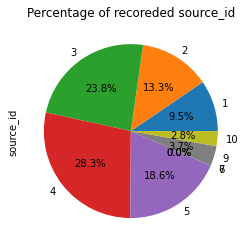


PERCENTAGE OF USERS WITH NUMBER OF UNIQUE SOURCE_ID:
1    83.468394
2    12.552976
3     2.976741
4     0.771796
5     0.193716
6     0.032432
7     0.003944
Name: source_id, dtype: float64


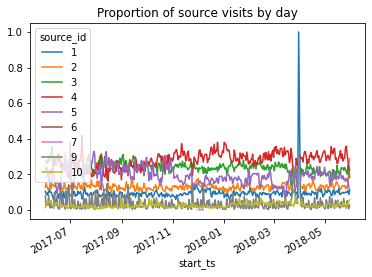

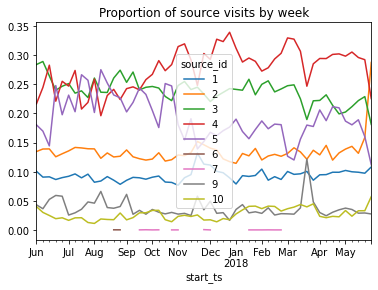

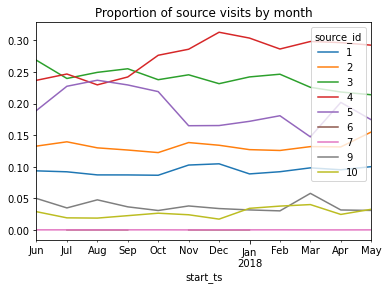

Distribution of duration_min for each source_id:


,count,mean,std,min,25%,50%,75%,max
source_id,,,,,,,,
1,34120.0,17.321542,24.385358,0.0,3.00,10.0,23.00,596.0
2,47626.0,14.077605,23.113540,0.0,2.00,7.0,18.00,524.0
3,85609.0,9.537794,14.144380,0.0,1.00,4.0,12.00,711.0
4,101794.0,9.330245,13.217501,0.0,1.00,4.0,12.00,381.0
5,66905.0,8.778118,12.586014,0.0,1.00,4.0,11.00,306.0
6,6.0,22.833333,38.007455,0.0,3.75,7.0,17.75,99.0
7,36.0,10.111111,16.104618,0.0,2.00,3.0,13.50,88.0
9,13276.0,9.437632,13.616173,0.0,1.00,4.0,12.00,178.0
10,10025.0,11.040100,17.088182,0.0,1.00,5.0,15.00,254.0


In [7]:
print('_'*10, 'ASSESSING VISITS BY SOURCE_ID', '_'*10)
print()

# Check how many source_id general contribution
dfs['visits']['source_id'].value_counts(sort=False).plot.pie(autopct='%1.1f%%', title='Percentage of recoreded source_id')
plt.show()
print()

# Check if one users can have more than 1 source_id recorded
print('PERCENTAGE OF USERS WITH NUMBER OF UNIQUE SOURCE_ID:')
print(dfs['visits'].groupby('uid')['source_id'].nunique().value_counts(normalize=True, sort=False)*100)

for level in time:
    dfs['visits'].groupby([dfs['visits']['start_ts'].astype(time[level])])['source_id'].value_counts(normalize=True).unstack(1).plot.line(title='Proportion of source visits by '+level)
    plt.show()

print('Distribution of duration_min for each source_id:')
dfs['visits'].groupby('source_id')['duration_min'].describe()

### COMMENT:
+ There are 9 visit source_id recorded, but the source 1 - 5 are dominant and nearly 75% of recorded visits are from source 3, 4 and 5. Very little visits recored from source 6 - 10.  

+ Source_id are not unique for user as nearly 17% of users have more than one source_id recorded (up to 7 sources).

+ There is some shift in contribution of the three main visit source (3,4 and 5) from October. This is also the time when server have higher visit flow)

+ While source 1-2 have lower visits counts than source 3-5, the visit sessions from these two source tend to be longer (around 15-20 min in average).

*NOTE: there is a date around April that the number of visits drop suddenly, the small amount of visits on that day seems to come only from source 1*



__________ ASSESSING VISITS BY DEVICE __________

PERCENTAGE OF RECORDED DEVICE:
desktop    73.057093
touch      26.942907
Name: device, dtype: float64

PERCENTAGE OF USERS WITH NUMBER OF UNIQUE DEVICE:
1    96.625747
2     3.374253
Name: device, dtype: float64


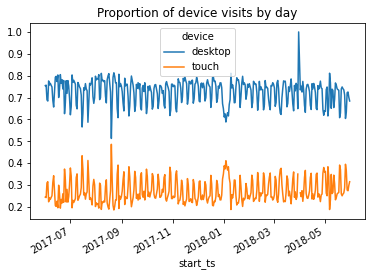

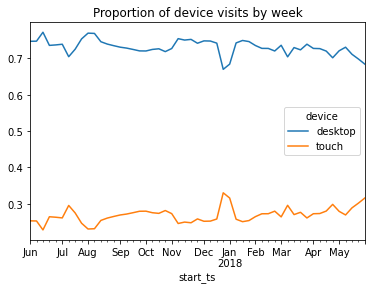

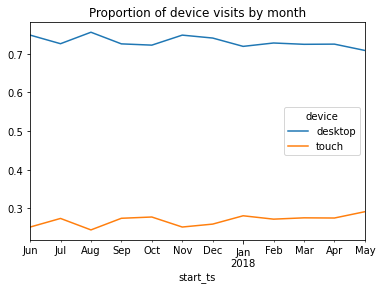

Distribution of duration_min for each device:


,count,mean,std,min,25%,50%,75%,max
device,,,,,,,,
desktop,262565.0,11.721079,17.784347,0.0,2.0,6.0,15.0,711.0
touch,96832.0,7.993039,12.542668,0.0,1.0,3.0,10.0,514.0


In [8]:
print('_'*10, 'ASSESSING VISITS BY DEVICE', '_'*10)
print()

# Check how many device types and each contribution
print('PERCENTAGE OF RECORDED DEVICE:')
print(dfs['visits']['device'].value_counts(normalize=True, sort=False)*100)
print()

# Check if one user can have more than 1 device recorded
print('PERCENTAGE OF USERS WITH NUMBER OF UNIQUE DEVICE:')
print(dfs['visits'].groupby('uid')['device'].nunique().value_counts(normalize=True, sort=False)*100)

for level in time:
    dfs['visits'].groupby([dfs['visits']['start_ts'].astype(time[level])])['device'].value_counts(normalize=True).unstack(1).plot.line(title='Proportion of device visits by '+level)
    plt.show()

print('Distribution of duration_min for each device:')
dfs['visits'].groupby('device')['duration_min'].describe()

### COMMENT:
+ The number of visit records are around 3:1 in ratio for desktop and touch. 

+ Compare to source_id, device platform are more unique for each users with more than 95% users have only 1 device recorded.

+ While desktop visit is more dominant, there seems to be a subtle shift to more touch device visits contribution. 

+ Visit sessions from desktop tend to be a little longer than touch.

# Did users come back? <a id="part_2c"></a>

__________ ASSESSING USERS RETENTION AND CHURN RATE FOR EACH USER COHORT __________



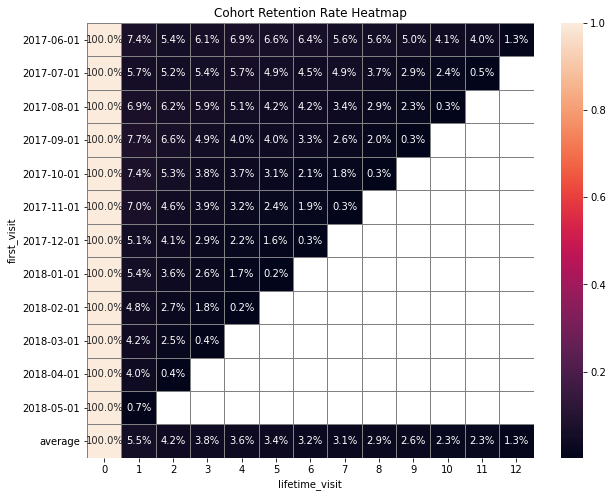

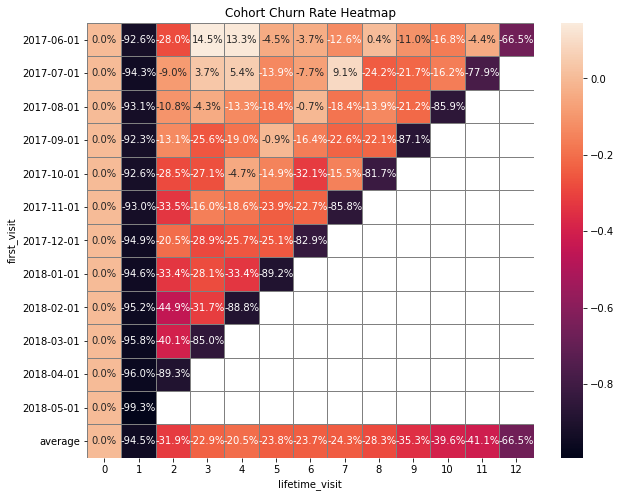

In [9]:
print('_'*10, 'ASSESSING USERS RETENTION AND CHURN RATE FOR EACH USER COHORT', '_'*10)
print()

visit_retention = Cohort_Retention(dfs['visits'])

visit_churn = Cohort_Churn(dfs['visits'])

### COMMENT:
The server manage to keep 5-7% visitors come back every months.

# SALES <a id="part_3"></a>
---
### SUMMARY:

+ There is around 140 orders/130 customers daily bringing around 700USD daily revenue. Orders and revenue is higher from Oct to March. However, conversion rates are not much different between first visit cohorts (around 11% converted within the first day)

+ 1 day conversion rate of source 1 (20%) is nearly 2 times higher than source 2,3,4 and 5 (around 10%). 1 day conversion rate of source 9 is relatively low (6%)

+ 1 day conversion rate of desktop (13%) is 2 times higher than touch device (6,5%)

+ Majority of customers have only 1 order records. LTV therefore is around 1 order size (5USD) in the first few months. LTV by 1 year is about 2 order size.

# Orders traffic <a id="part_3a"></a>

__________ ASSESSING ORDERS BY DATE __________



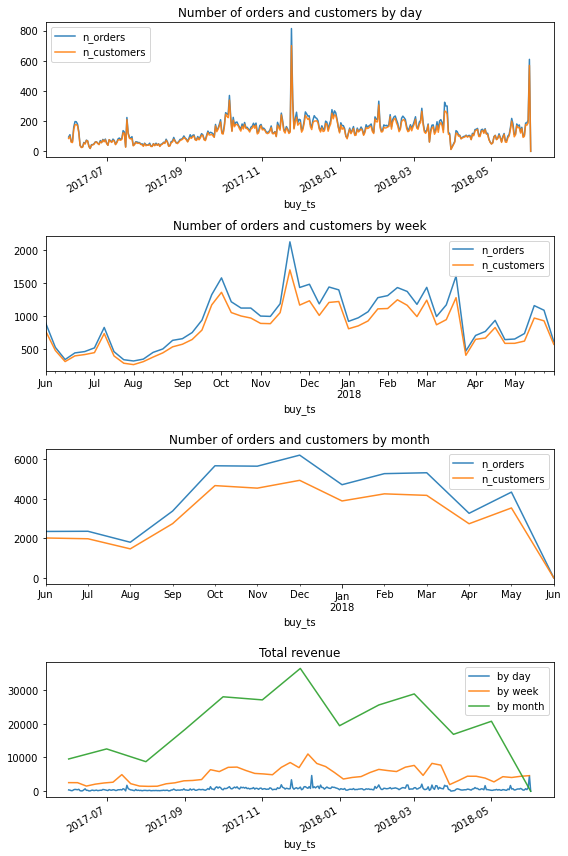

,day_average,week_average,month_average,total
n_orders,138.502747,951.226415,3878.076923,50415.000000
n_customers,127.879121,818.094340,3155.307692,36523.000000
sum_revenue,692.464835,4755.796226,19389.015385,252057.200000
n_orders/customer,1.083076,1.162734,1.229065,1.380363
revenue/order,4.999647,4.999647,4.999647,4.999647


In [10]:
print('_'*10, 'ASSESSING ORDERS BY DATE', '_'*10)
print()

orders_date_ave = pd.DataFrame([])             # report dataframe
fig, axes = plt.subplots(4, figsize=(8, 12))    # plot 

a=0
for level in time: # to round up 'start_ts' to date/week/month level
    
    # count orders, customers and sum revenue buy round buy_ts
    orders_date = dfs['orders'].groupby(dfs['orders']['buy_ts'].astype(time[level])).agg({'uid':['count', 'nunique'], 'revenue': 'sum'})
    orders_date.columns = ['n_orders', 'n_customers', 'sum_revenue']

    # plot n_orders/n_customers
    orders_date[['n_orders', 'n_customers']].plot.line(alpha=0.9, ax=axes[a],
                                            title=('Number of orders and customers by ' + level))
    orders_date['sum_revenue'].plot.line(alpha=0.9, ax=axes[3], 
                                            title='Total revenue', label=('by '+level) )
    a+=1

    # calculate average and add to report
    orders_date_ave[level+'_average'] = orders_date.mean()

axes[a].legend()

orders_date_ave['total'] = dfs['orders'].agg({'buy_ts':'count', 'uid':'nunique', 'revenue': 'sum'}).tolist()
orders_date_ave.loc['n_orders/customer'] = orders_date_ave.loc['n_orders']/orders_date_ave.loc['n_customers']
orders_date_ave.loc['revenue/order'] = orders_date_ave.loc['sum_revenue']/orders_date_ave.loc['n_orders']

plt.tight_layout()
plt.show()

orders_date_ave

### COMMENT:
+ There is around 140 orders - 130 customers daily bringing around 700$ daily.

+ Changing in number of orders/customers and revenue through time is very similar with changing in number of visits/visitors through time as seen in previous part.

# When did users start buying? <a id="part_3b"></a>

__________ STUDY CUSTOMER CONVERSION RATE BY COHORTS __________



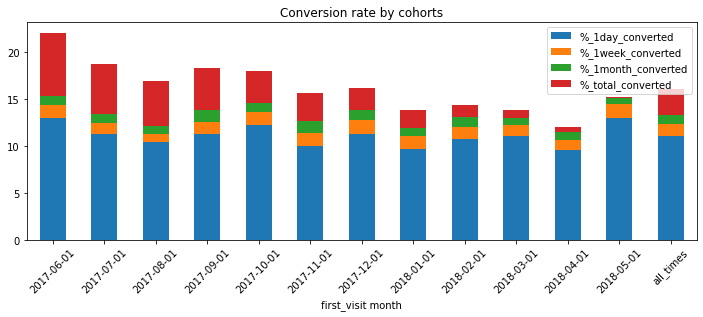

,%_1day_converted,%_1week_converted,%_1month_converted,%_total_converted
2017-06-01,13.010031,14.360057,15.325439,22.045403
2017-07-01,11.240487,12.450533,13.340944,18.706240
2017-08-01,10.460662,11.246439,12.071506,16.904037
2017-09-01,11.302682,12.559866,13.829023,18.306992
2017-10-01,12.206952,13.554298,14.605228,18.008238
2017-11-01,10.015414,11.421022,12.657810,15.641515
2017-12-01,11.283046,12.703815,13.800063,16.123160
2018-01-01,9.697666,11.045792,11.920969,13.786245
2018-02-01,10.713159,12.051178,13.046808,14.353291
2018-03-01,11.001020,12.171548,12.914663,13.784059


In [11]:
print('_'*10, 'STUDY CUSTOMER CONVERSION RATE BY COHORTS', '_'*10)
print()

#calculate
CVR = pd.DataFrame([])
for month in sorted(dfs['visits']['first_visit'].astype('datetime64[M]').unique()):
    CVR[pd.to_datetime(month).strftime('%Y-%m-%d')] = CVR_Time(stage1 = dfs['visits'][dfs['visits']['first_visit'].astype('datetime64[M]')==month], stage2 = dfs['orders'])
CVR['all_times'] = CVR_Time(stage1 = dfs['visits'], stage2 = dfs['orders'])
CVR.index = ('%_1day_converted', '%_1week_converted', '%_1month_converted', '%_total_converted')

#graph data
ax = (CVR.T - CVR.T.shift(axis=1).fillna(0)).plot.bar(rot=45, stacked=True, title='Conversion rate by cohorts', figsize=(12,4))
ax.set_xlabel('first_visit month')
plt.show()

#table data
CVR.T

### COMMENT:
+ 1 days/weeks/months conversion rates are not too much different between cohorts.

+ Total conversion rates, however, are higher for older cohorts.

__________ STUDY CUSTOMER CONVERSION RATE BY SOURCE_ID __________



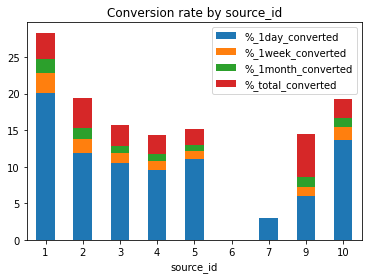

,%_1day_converted,%_1week_converted,%_1month_converted,%_total_converted
1,20.074741,22.769619,24.732881,28.317280
2,11.865117,13.743570,15.252429,19.352258
3,10.476751,11.830489,12.881909,15.777998
4,9.605507,10.849446,11.796468,14.350195
5,11.073472,12.126584,12.946256,15.140239
6,0.000000,0.000000,0.000000,0.000000
7,2.941176,2.941176,2.941176,2.941176
9,5.958549,7.253886,8.603195,14.518566
10,13.697781,15.396058,16.685261,19.288459


In [12]:
print('_'*10, 'STUDY CUSTOMER CONVERSION RATE BY SOURCE_ID', '_'*10)
print()

CVR = pd.DataFrame([])
for id in sorted(dfs['visits']['source_id'].unique()):
    CVR[id] = CVR_Time(stage1 = dfs['visits'][dfs['visits']['source_id']==id], stage2 = dfs['orders'])    

CVR.index = ('%_1day_converted', '%_1week_converted', '%_1month_converted', '%_total_converted')

ax = (CVR.T - CVR.T.shift(axis=1).fillna(0)).plot.bar(rot = 0, stacked=True, title='Conversion rate by source_id')
#CVR.T.plot.bar(rot = 0, title='Conversion rate by source_id') #side by side columns, not stacked
ax.set_xlabel('source_id')
plt.show()

CVR.T

### COMMENT:
+ Around 2/3 customers are converted within 1 days.

+ Source 1 have the highest conversion rate 20% within day and nearly 30% in total.

__________ STUDY CUSTOMER CONVERSION RATE BY DEVICE __________



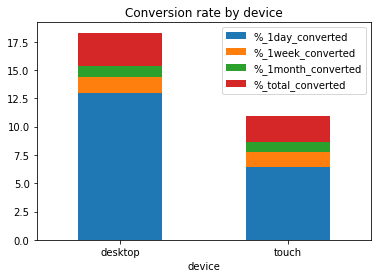

,%_1day_converted,%_1week_converted,%_1month_converted,%_total_converted
desktop,12.984811,14.349361,15.397847,18.297746
touch,6.475576,7.720233,8.599061,10.918775


In [13]:
print('_'*10, 'STUDY CUSTOMER CONVERSION RATE BY DEVICE', '_'*10)
print()

CVR = pd.DataFrame([])
for pf in sorted(dfs['visits']['device'].unique()):
    CVR[pf] = CVR_Time(stage1 = dfs['visits'][dfs['visits']['device']==pf], stage2 = dfs['orders'])

CVR.index = ('%_1day_converted', '%_1week_converted', '%_1month_converted', '%_total_converted')

ax = (CVR.T - CVR.T.shift(axis=1).fillna(0)).plot.bar(rot = 0, stacked=True, title='Conversion rate by device')
ax.set_xlabel('device')
plt.show()

CVR.T

### COMMENT:
Desktop have about 2 times higher conversion rate compare to touch device.

# How much money did customers bring? <a id="part_3c"></a>

__________ ACCESSING CUSTOMER LTV BY COHORTS __________



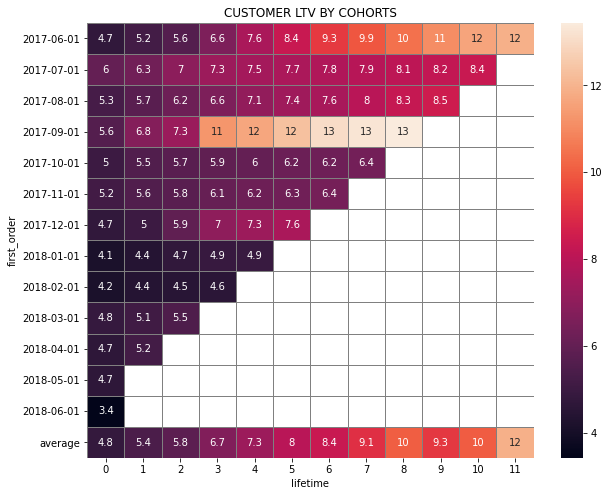

In [14]:
print('_'*10, 'ACCESSING CUSTOMER LTV BY COHORTS', '_'*10)
print()
LTV = Cohort_LTV(dfs['orders'], heatmap=True)

### COMMENT:
+ 1 customer normally bring 5$ the the first few months (around 1 order size) 

+ LTV increase to around 10$ by 1 year lifetime.

# MARKETING <a id="part_4"></a>
---
### SUMMARY:

+ The average daily cost around 900$. Costs is also higher from Oct to March expecially for source 3

+ CAC is not much different between monthly cohorts (arond 9USD) but vary strongly between different sources. CAC of source 1, 9 and 10 are around 4USD less than 1 order size while CAC of source 2 and 3 is much higher (9 - 12USD).

+ The current marketing investments would not be paid off even by the 8th months lifetime.


# Marketing cost <a id="part_4a"></a>

__________ ASSESSING MARKETING COSTS BY DATE __________



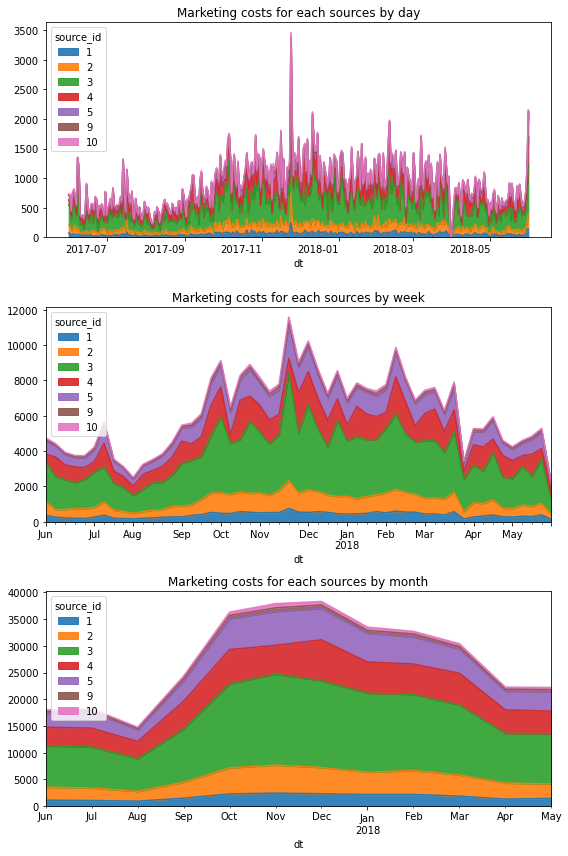

,ave_per_day,ave_per_week,ave_per_month,all_time,%_total
source_id,,,,,
1,57.391928,393.080566,1736.105833,20833.27,6.329769
2,117.922975,807.661132,3567.170000,42806.04,13.005751
3,389.315785,2666.445849,11776.802500,141321.63,42.937725
4,168.246832,1152.332075,5089.466667,61073.60,18.555981
5,142.189835,976.549057,4313.091667,51757.10,15.725350
9,15.199697,104.103585,459.790833,5517.49,1.676378
10,16.039917,109.858302,485.207500,5822.49,1.769046
all_sources,904.207747,6210.030566,27427.635000,329131.62,100.000000


In [15]:
print('_'*10, 'ASSESSING MARKETING COSTS BY DATE', '_'*10)
print()

total_expenses = dfs['expenses']['costs'].sum()

expenses_date_ave = pd.DataFrame([])   
all_sources = []

fig, axes = plt.subplots(3, figsize=(8,12))    

a=0
for level in time:    
    expenses_date = dfs['expenses'].pivot_table(index= dfs['expenses']['dt'].astype(time[level]), columns= 'source_id', values='costs', aggfunc='sum')   

    expenses_date.plot.area(alpha=0.9, ax=axes[a], rot=0)
    axes[a].set_title('Marketing costs for each sources by ' + level)
    a+=1

    expenses_date_ave['ave_per_' + level] = expenses_date.mean() 

    all_sources.append(dfs['expenses'].groupby(dfs['expenses']['dt'].astype(time[level]))['costs'].sum().mean())

plt.tight_layout()
plt.show()

all_sources.append(total_expenses)

expenses_date_ave['all_time'] = dfs['expenses'].groupby('source_id')['costs'].sum()
expenses_date_ave.loc['all_sources'] = all_sources
expenses_date_ave['%_total'] = expenses_date_ave['all_time']/total_expenses*100

expenses_date_ave

### COMMENT:
+ The marketing costs changing through time and very simimlar to the number of visits/orders records.

+ However the distribution of costs to each soure_id does not seem to matched with the distribution of visits or revenue. Costs for source 3 are significantly much higher than all other sources.

+ The average daily cost around 900$ is higher than the average daily revenue.

# How much did customer acquisition cost? <a id="part_4b"></a>

In [16]:
print('_'*10, 'ACCESSING AVERAGE CAC BY COHORT SOURCE_ID', '_'*10)
print()

print('General customer acquisition cost(CAC): {:.2f}'.format(dfs['expenses']['costs'].sum()/dfs['orders']['uid'].nunique()))

CAC = pd.DataFrame([])

for id in dfs['expenses']['source_id'].unique():
    #find user first visit time from each specific source
    visits = dfs['visits'][dfs['visits']['source_id']==id].groupby('uid')['start_ts'].min().reset_index() 
    # merge to orders df
    orders = dfs['orders'].merge(visits, on='uid', how='left') 
    #if customers first_order happened not before the first visit from that source, customer are counted as being converted by this source
    orders = orders[orders['first_order']>= orders['start_ts']] 
    # calculate cohort CAC: divide expenses by total number of converted users       
    CAC[id] = dfs['expenses'][dfs['expenses']['source_id']==id].groupby(dfs['expenses']['dt'].astype('datetime64[M]').dt.strftime('%Y-%m-%d'))['costs'].sum()/orders.groupby(orders['first_order'].astype('datetime64[M]').dt.strftime('%Y-%m-%d'))['uid'].nunique()

CAC['all_sources'] = dfs['expenses'].groupby(dfs['expenses']['dt'].astype('datetime64[M]').dt.strftime('%Y-%m-%d'))['costs'].sum()/dfs['orders'].groupby(dfs['orders']['first_order'].astype('datetime64[M]').dt.strftime('%Y-%m-%d'))['uid'].nunique()
CAC.loc['average'] = CAC.mean()
CAC.style.background_gradient(cmap='coolwarm').set_precision(2)

__________ ACCESSING AVERAGE CAC BY COHORT SOURCE_ID __________

General customer acquisition cost(CAC): 9.01


,1,2,3,4,5,9,10,all_sources
dt,,,,,,,,
2017-06-01,3.99,8.83,11.54,8.01,6.17,4.13,3.05,8.91
2017-07-01,3.76,8.61,14.03,6.23,6.13,5.22,5.89,9.49
2017-08-01,5.17,10.72,16.92,8.51,5.63,3.51,5.67,10.80
2017-09-01,4.03,9.19,11.96,7.68,5.45,4.33,5.01,9.44
2017-10-01,3.95,8.86,12.37,4.82,5.15,4.09,2.79,8.37
2017-11-01,3.64,8.57,12.18,3.81,7.17,3.73,5.08,9.29
2017-12-01,3.45,8.34,10.76,4.72,6.21,4.42,6.04,8.74
2018-01-01,4.43,9.54,12.87,4.79,6.66,5.02,5.80,9.94
2018-02-01,4.32,9.79,11.37,4.39,5.76,5.30,3.16,8.96


### COMMENT:
+ CAC is not much different between monthly cohorts and around 9$

+ CAC of source 1, 9 and 10 are relatively small (less than an average purchase size).  
CAC of source 2 and 3 are quite hight, especially source 3 average CAC is higher than average 1 year LTV.

# How worthwhile were the investments? <a id="part_4c"></a>

__________ ACCESSING MARKETING ROMI __________



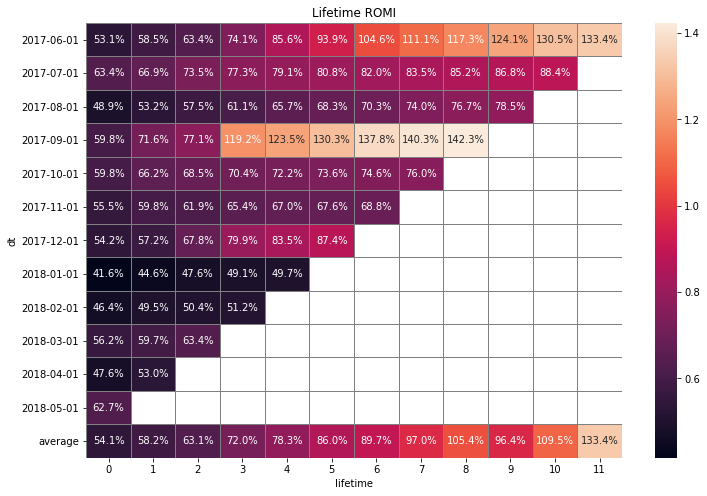

In [17]:
print('_'*10, 'ACCESSING MARKETING ROMI', '_'*10)
print()

revenue = Cohort_LTV(dfs['orders'], heatmap=False)

costs = dfs['expenses'].groupby(dfs['expenses']['dt'].astype('datetime64[M]'))['costs'].sum().reset_index()

report = pd.merge(revenue, costs, left_on='first_order', right_on='dt')
report['romi'] = report['revenue']/report['costs']
report['dt'] = report['dt'].dt.strftime('%Y-%m-%d')

report = report.pivot_table(index='dt', columns='lifetime', values='romi', aggfunc='mean').cumsum(axis=1)
report.loc['average'] = report.mean()
plt.figure(figsize=(12,8))
plt.title('Lifetime ROMI')
sns.heatmap(report, annot=True, fmt='.1%', linewidths=1, linecolor='gray')
plt.show()


### COMMENT:
In general, the current marketing investments would not be paid off even by the 8th months lifetime.

# FINAL CONCLUSION: <a id="part_5"></a>

**Server have around 1000 visits (900 visitors), 140 orders (130 customers), 700USD revenue and 900USD cost on daily basic**. Visit, order and cost are relatively higher from October to March.  


Around **11% visitors are converted to customer within 1 day (13% within 1 month)**. This rate is not much different between monthly cohorts. Visitors can still be converted at much later time as the total conversion rate of the few first cohorts are around 20%.  


**Users mainly visit from source 3-4-5 followed by source 1-2 and very little from source 6-7-8-9-10**. Ratio between desktop and touch visits around 3:1.  


**Distribution of costs is not well correlated to the distribution of visits with source 3 take much larger share in the marketing costs compare to other sources**. Therefore, while CAC of source 1-9-10 are around 4USD, CAC of source 2-3 are much higher (9 - 12USD).  


In general CAC is around 9USD and not much different between cohorts but LTV is just around 1 order size (5USD) in the first few month. **The current marketing investments would not be paid off even by the 8th months lifetime**.  


For optimization, it is better to shift the investment from source 3 with too high CAC to source 1 with lower CAC and higher conversion rate.  


---
*end*